<img src="https://raw.githubusercontent.com/instill-ai/cookbook/main/images/Logo.png" alt="Instill Logo" width="300"/>

# Generating Structured Output from LLMs

In this notebook, we will explore the performance of OpenAI's new [Structured Outputs in the
API](https://openai.com/index/introducing-structured-outputs-in-the-api/) feature, alongside multiple existing tools for generating structured outputs from LLMs. As well as providing a concise demonstration of how to use all of these tools, we will also evaluate them with respect to a task that involves both **reasoning** and **structuring outputs**, inspired by the recent publication titled [Let Me Speak Freely? A Study on the Impact of Format Restrictions on Performance of Large Language Models](https://arxiv.org/abs/2408.02442v1).

This illuminates an important problem raised in the paper: **LLMs struggle with reasoning tasks when they're placed under format restrictions**.

Besides OpenAI's new structured outputs in the API, the existing tools and libraries that we will demonstrate and test are:

1. [**Instructor**](https://python.useinstructor.com) - a Python library, built on top of Pydantic, that lets you generate structured output from LLMs
2. [**Marvin**](https://www.askmarvin.ai) - a Python library for building reliable natural language interfaces
3. [**BAML**](https://www.boundaryml.com) - a domain specific language to write and test LLM functions
4. [**TypeChat**](https://microsoft.github.io/TypeChat/) - a tool from Microsoft for getting well-typed responses from language models
5. [**LangChain**](https://www.langchain.com) - a Python library that simplifies building apps with language models by integrating them with data and APIs

[Outlines](https://outlines-dev.github.io/outlines/), [JSONformer](https://github.com/1rgs/jsonformer) and [Guidance](https://github.com/guidance-ai/guidance/tree/main) were also considered, however they were left out of this experiment as they had limited support for remote API calls and failed when integrating with the OpenAI API.

Finally, we will demonstrate a multi-step approach using Instill VDP, where we separate reasoning from output structuring in a two-step process that allows us to achieve strong reasoning performance from LLMs whilst also producing robust structured outputs.

### Setup

To execute all of the code in this notebook, you’ll need to create a free Instill Cloud account and setup an API Token. To create your account, please refer to our [quickstart guide](https://www.instill.tech/docs/quickstart). For generating your API Token, consult the [API Token Management](https://www.instill.tech/docs/core/token) page.

**This will give you access to 10,000 free credits per month that you can use to make API calls with third-party AI vendors. Please see our [documentation](https://www.instill.tech/docs/cloud/credit) for further details.**

Whilst you can run all Instill VDP pipelines using your 10,000 free monthly credits, please note that you will need a valid OpenAI API key to run the structured LLM output evaluations (e.g. for Instructor, Marvin, BAML, TypeChat). Once you have created one via the OpenAI website, please set it as an environment variable by running the following line, but replacing `*********` for your OpenAI API key.

In [ ]:
!export OPENAI_API_KEY='**********'

We will now install the latest Instill Python SDK, import the required libraries, and configure the SDK with a valid API token.

In [1]:
!pip install instill-sdk==0.15.1 --quiet

In [3]:

from IPython.display import IFrame
import os
from google.protobuf.json_format import MessageToDict
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from instill.clients import init_pipeline_client
pipeline = init_pipeline_client(api_token="YOUR_INSTILL_API_TOKEN")

### Benchmark Task

The task we will use to test, compare and evaluate the performance of these tools is directly inspired from Figure 1 of the aforementioned [paper](https://arxiv.org/abs/2408.02442v1), which poses the question:

> Eliza's rate per hour for the first 40 hours she works each week is $10. She also receives an overtime pay of 1.2 times her regular hourly rate. If Eliza worked for 45 hours this week, how much are her earnings for this week?

In our task, we increase the complexity by combining an analogous reasoning problem with an additional text summarization task. More precisely, we ask the LLM/output structuring tool to summarize the contents of a resume into the following data model:
```Python
name: str
email: str
cost: float
experience: list[str]
skills: list[str]
```
where `cost` represents the answer to the question:
> John Doe is a freelance software engineer. He charges a 
        base rate of $50 per hour for the first 29 hours of work 
        each week. For any additional hours, he charges 1.7 
        times his base hourly rate. This week, John worked on a 
        project for 38 hours. How much will John Doe charge his 
        client for the project this week?

and `reasoning` contains the rationale and steps behind the calculated cost. See below for the example resume we will use, as well as the correct `cost` response.

In [4]:
resume = """
    John Doe
    1234 Elm Street 
    Springfield, IL 62701
    (123) 456-7890
    Email: john.doe@gmail.com

    Objective: To obtain a position as a software engineer.

    Education:
    Bachelor of Science in Computer Science
    University of Illinois at Urbana-Champaign
    May 2020 - May 2024

    Experience:
    Software Engineer Intern
    Google
    May 2022 - August 2022
    - Worked on the Google Search team
    - Developed new features for the search engine
    - Wrote code in Python and C++

    Software Engineer Intern
    Facebook
    May 2021 - August 2021
    - Worked on the Facebook Messenger team
    - Developed new features for the messenger app
    - Wrote code in Python and Java
    """

question = """
    Question:
    John Doe is a freelance software engineer. He charges a 
    base rate of $50 per hour for the first 29 hours of work 
    each week. For any additional hours, he charges 1.7 
    times his base hourly rate. This week, John worked on a 
    project for 38 hours. How much will John Doe charge his 
    client for the project this week?
    """

context = resume + question

#### Correct Answer

In [5]:
true_answer = (50*29) + (1.7*50*9)
print(f'Correct Answer: ${true_answer}')

Correct Answer: $2215.0


### OpenAI GPT-4o Performance Baseline

Before we take a look at various libraries and frameworks that aim to produce structured outputs from LLMs, we will first test and evaluate the performance of GPT-4o on this task, with and without enforcing structured output, by making use of the new OpenAI structured output API that is now supported in Instill VDP.

#### Unstructured Output

Here we call the [`unstructured-output`](https://instill.tech/george_strong/pipelines/unstructured-output/playground) Instill VDP pipeline to test the performance of OpenAI's GPT4o model on this task without any restriction on the output structure. It achieves the correct result.

In [5]:
openai_unstructured = pipeline.trigger(
    namespace_id="george_strong",
    pipeline_id="unstructured-output",
    data=[{"context": context,
           "question": question}]
)

openai_unstructured_dict = MessageToDict(openai_unstructured)['outputs'][0]['answer']
print(openai_unstructured_dict)

To answer the question about how much John Doe will charge his client for the project this week:

1. Base hourly rate = $50
2. First 29 hours charge = 29 hours * $50/hour = $1,450
3. Additional hours worked = 38 hours - 29 hours = 9 hours
4. Rate for additional hours = 1.7 * $50 = $85/hour
5. Charge for additional hours = 9 hours * $85/hour = $765
6. Total charge = $1,450 + $765 = $2,215

Therefore, John Doe will charge his client $2,215 for the project this week.

Additional details regarding the candidate:

1. **Name**: John Doe
2. **Email**: john.doe@gmail.com
3. **Experience**:
   - Software Engineer Intern at Google (May 2022 - August 2022)
     - Worked on the Google Search team
     - Developed new features for the search engine
     - Wrote code in Python and C++
   - Software Engineer Intern at Facebook (May 2021 - August 2021)
     - Worked on the Facebook Messenger team
     - Developed new features for the messenger app
     - Wrote code in Python and Java
4. **Skills**:
  

#### Structured Output

Here we call the [`structured-output`](https://instill.tech/george_strong/pipelines/structured-output/playground) Instill VDP pipeline, which makes use of the new Structured Outputs in the API feature. Although the same model was able to calculate the correct result when generating unstructured text output, by restricting the output format to our structured data model, we can observe that the `cost` result is incorrect.

In [6]:
openai_structured = pipeline.trigger(
    namespace_id="george_strong",
    pipeline_id="structured-output",
    data=[{"context": context,
           "question": question}]
)

openai_structured_dict = MessageToDict(openai_structured)['outputs'][0]['answer']
openai_structured_dict

{'cost': 2265.0,
 'email': 'john.doe@gmail.com',
 'experience': ['Software Engineer Intern at Google',
  'Software Engineer Intern at Facebook'],
 'skills': ['Python', 'C++', 'Java'],
 'name': 'John Doe'}

In [7]:
structured_output_error = abs(openai_structured_dict["cost"]-true_answer)
print(f'Cost calculation error: ${structured_output_error}')

Cost calculation error: $50.0


### 1. Instructor

[Instructor](https://python.useinstructor.com) is a Python library, built on top of Pydantic, that lets you generate structured output from LLMs. Here is how you can easily get started with it, and test its performance on the benchmark task.

In [8]:
!pip install instructor==1.4.0 --quiet
import instructor
from pydantic import BaseModel
from openai import OpenAI

In [9]:
class DataModel(BaseModel):
    name: str
    email: str
    cost: float
    experience: list[str]
    skills: list[str]


instructor_client = instructor.from_openai(OpenAI())

template = """
    Extract from this content:
    {resume}
    Answer the question, storing the result in cost.
    """

prompt = template.format(resume=context)

instructor_response = instructor_client.chat.completions.create(
    model="gpt-4o",
    response_model=DataModel,
    messages=[{"role": "user", "content": prompt}],
    temperature=1,
)

instructor_dict = instructor_response.model_dump()
instructor_dict

2024-09-09 15:46:26,793.793 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'name': 'John Doe',
 'email': 'john.doe@gmail.com',
 'cost': 2136.0,
 'experience': ['Software Engineer Intern, Google, May 2022 - August 2022',
  'Software Engineer Intern, Facebook, May 2021 - August 2021'],
 'skills': ['Python', 'C++', 'Java']}

In [10]:
instructor_error = abs(instructor_dict["cost"]-true_answer)
print(f'Cost calculation error: ${instructor_error}')

Cost calculation error: $79.0


### 2. Marvin

[Marvin](https://www.askmarvin.ai) is a Python library for building reliable natural language interfaces. Here is how you can easily get started with it, and test its performance on the benchmark task.

In [11]:
!pip install marvin==2.3.7 --quiet
import marvin

In [12]:
marvin.settings.openai.chat.completions.model = 'gpt-4o'


@marvin.fn
def process(
    resume:str = resume,
    question: str = question,
) -> DataModel:
    """
    Extract content from `resume`.
    Answer the `question`, storing the result in cost.
    """


marvin_response = process(resume, question)

marvin_dict = marvin_response.model_dump()
marvin_dict

2024-09-09 15:46:56,283.283 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'name': 'John Doe',
 'email': 'john.doe@gmail.com',
 'cost': 2265.0,
 'experience': ['Software Engineer Intern at Google (May 2022 - August 2022)',
  'Software Engineer Intern at Facebook (May 2021 - August 2021)'],
 'skills': ['Python', 'C++', 'Java']}

In [13]:
marvin_error = abs(marvin_dict["cost"]-true_answer)
print(f'Cost calculation error: ${marvin_error}')

Cost calculation error: $50.0


### 3. BAML

[BAML](https://www.boundaryml.com) is a domain specific language to write and test LLM functions developed by Boundary. Here is how you can easily get started with it, and test its performance on the benchmark task.

In [14]:
!pip install baml-py==0.54.0 --quiet
!baml-cli init

In [15]:
file_path = 'baml_src/clients.baml'

with open(file_path, 'r') as file:
    file_data = file.read()

updated_file_data = file_data.replace(
    'client<llm> GPT4 {\n  provider openai\n  options {\n    model "gpt-4"\n    api_key env.OPENAI_API_KEY\n  }\n}',
    'client<llm> GPT4o {\n  provider openai\n  options {\n    model "gpt-4o"\n    api_key env.OPENAI_API_KEY\n  }\n}'
)

with open(file_path, 'w') as file:
    file.write(updated_file_data)

In [16]:
file_path = 'baml_src/resume.baml'

with open(file_path, 'r') as file:
    file_data = file.read()

updated_file_data = file_data.replace(
    '// Defining a data model.\nclass Resume {\n  name string\n  email string\n  experience string[]\n  skills string[]\n}',
    '// Defining a data model.\nclass Resume {\n  name string\n  email string\n  cost float\n  experience string[]\n  skills string[]\n}'
    ).replace(
    'Extract from this content:\n    {{ resume }}\n\n',
    'Extract from this content:\n    {{ resume }}\n    Answer the question, storing the result in cost.\n\n'
    ).replace(
    'client GPT4',
    'client GPT4o'
    )

with open(file_path, 'w') as file:
    file.write(updated_file_data)

In [17]:
!baml-cli generate
from baml_client.sync_client import b

Generated 1 baml_client


In [18]:
baml_response = b.ExtractResume(context)

baml_dict = baml_response.model_dump()
baml_dict

{'name': 'John Doe',
 'email': 'john.doe@gmail.com',
 'cost': 2179.0,
 'experience': ['Google', 'Facebook'],
 'skills': ['Python', 'C++', 'Java']}

In [19]:
baml_error = abs(baml_dict["cost"]-true_answer)
print(f'Cost calculation error: ${baml_error}')

Cost calculation error: $36.0


### 4. TypeChat

[TypeChat](https://microsoft.github.io/TypeChat/) is a tool from Microsoft for getting well-typed responses from language models. Here is how you can easily get started with it, and test its performance on the benchmark task.

In [20]:
!pip install "typechat @ git+https://github.com/microsoft/TypeChat#subdirectory=python" --quiet
from dataclasses import dataclass
from typing_extensions import Annotated, Doc
from typing import Dict, Any
from typechat import TypeChatJsonTranslator, TypeChatValidator, create_language_model

In [21]:
@dataclass
class TypeChatDataModel:
    name: Annotated[str, Doc("The name of the candidate")]
    email: Annotated[str, Doc("The email address of the candidate")]
    cost: Annotated[float, Doc("The cost of hiring the candidate for the project")]
    experience: Annotated[list[str], Doc("A list of experiences the candidate has")]
    skills: Annotated[list[str], Doc("A list of skills the candidate possesses")]

    def to_dict(self) -> Dict[str, Any]:
        return {
            "name": self.name,
            "email": self.email,
            "cost": self.cost,
            "experience": self.experience,
            "skills": self.skills,
        }


env_vars = {'OPENAI_API_KEY': os.getenv('OPENAI_API_KEY'), 'OPENAI_MODEL': 'gpt-4o'}

model = create_language_model(env_vars)
validator = TypeChatValidator(TypeChatDataModel)
translator = TypeChatJsonTranslator(model, validator, TypeChatDataModel)

# TypeChat needed a little more help in the prompt to generate the output as numeric value!
typechat_response = await translator.translate(prompt)

typechat_dict = typechat_response.value.to_dict()
typechat_dict

2024-09-09 15:48:29,085.085 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'name': 'John Doe',
 'email': 'john.doe@gmail.com',
 'cost': 2115.0,
 'experience': ['Software Engineer Intern at Google (May 2022 - August 2022)',
  'Software Engineer Intern at Facebook (May 2021 - August 2021)'],
 'skills': ['Python', 'C++', 'Java']}

In [22]:
typechat_error = abs(typechat_dict["cost"]-true_answer)
print(f'TypeChat error: ${typechat_error}')

TypeChat error: $100.0


### 5. LangChain

LangChain simplifies building apps with language models by integrating them with data and APIs. Here is how you can easily get started with it, and test its performance on the benchmark task.

In [23]:
!pip install langchain==0.2.15 --quiet
!pip install langchain-openai==0.1.23 --quiet
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI

In [24]:
class LangChainDataModel(BaseModel):
    name: str = Field(description="The name of the candidate")
    email: str = Field(description="The email address of the candidate")
    cost: float = Field(description="The cost of hiring the candidate for the project")
    experience: list[str] = Field(description="A list of experiences the candidate has")
    skills: list[str] = Field(description="A list of skills the candidate possesses")


model = ChatOpenAI(model="gpt-4o", temperature=1)
structured_llm = model.with_structured_output(LangChainDataModel)

langchain_response = structured_llm.invoke(prompt)

langchain_dict = langchain_response.dict()
langchain_dict

2024-09-09 15:49:18,442.442 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'name': 'John Doe',
 'email': 'john.doe@gmail.com',
 'cost': 2035.0,
 'experience': ['Software Engineer Intern at Google',
  'Software Engineer Intern at Facebook'],
 'skills': ['Python', 'C++', 'Java']}

In [25]:
langchain_error = abs(langchain_dict["cost"]-true_answer)
print(f'LangChain error: ${langchain_error}')

LangChain error: $180.0


### Initial Evaluation

As illustrated in the below plot, the different blends of prompt engineering, output parsing and error handling used by each tool produce different reasoning errors when enforcing structured outputs. Despite variation in the error per tool used, it is important to note that _all_ methods failed on this task and would be unusable in any realistic production setting where reasoning of a similar complexity is required.

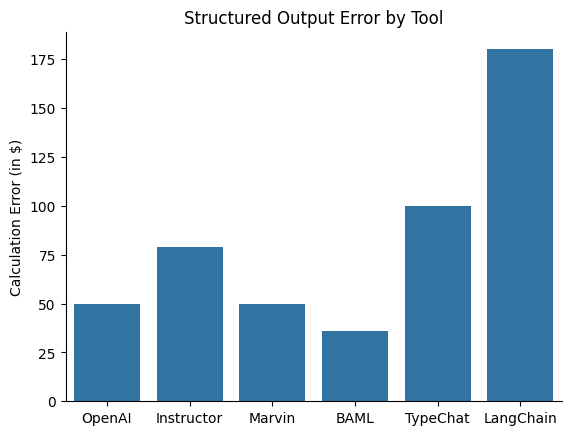

In [28]:
results = [structured_output_error, instructor_error, marvin_error, baml_error, typechat_error, langchain_error]
titles = ['OpenAI', 'Instructor', 'Marvin', 'BAML', 'TypeChat', 'LangChain']

sns.barplot(x=titles, y=results)

plt.title('Structured Output Error by Tool')
plt.ylabel('Calculation Error (in $)')

sns.despine()

plt.show()

### The Solution: Multi-Step Approach Using **💧 Instill VDP**

This problem is easily solved using an Instill VDP pipeline that separates reasoning and structuring tasks into a two-step process. It first generates an unstructured reasoning response which is then passed to a second component which is solely responsible for structuring the reasoning response into the desired data model. The final output is delivered as a JSON object.

Please see the [`multistep-structured-output`](https://instill.tech/george_strong/pipelines/multistep-structured-output/playground) pipeline preview and README for further details.

In [3]:
IFrame('https://instill.tech/george_strong/pipelines/multistep-structured-output/preview', width=1000, height=800)

In [28]:
openai_multi_structured = pipeline.trigger(
    namespace_id="george_strong",
    pipeline_id="multistep-structured-output",
    data=[{"context": context,
           "question": question}]
)

openai_multi_structured_dict = MessageToDict(openai_multi_structured)['outputs'][0]['answer']
openai_multi_structured_dict

{'cost': 2215.0,
 'email': 'john.doe@gmail.com',
 'experience': ['Software Engineer Intern at Google (May 2022 - August 2022)',
  'Software Engineer Intern at Facebook (May 2021 - August 2021)'],
 'skills': ['Python', 'C++', 'Java'],
 'name': 'John Doe'}

In [29]:
multi_structured_output_error = abs(openai_multi_structured_dict["cost"]-true_answer)
print(f'Cost calculation error: ${multi_structured_output_error}')

Cost calculation error: $0.0


Despite using two LLM inferences involved in this multi-step pipeline, it is worth noting that the cost will likely still be less than many of the structuring output tools that have been considered, as these often rely on making repeat API calls with modified prompts until the output can be successfully parsed into the required data model.

### Benchmarking Structured Outputs

⚠️ **Warning** - This section involves running multiple API calls using your configured OpenAI and Instill AI API tokens. If you do not want to be charged for re-running this benchmark, please do not run this cell.

Here, we benchmark the performance of each output structuring method by running multiple inferences with each. We then visualize the distributions of errors with respect to true cost value ($2215), calculate performance metrics, and conduct statistical tests to determine if the observed deviations are statistically significant.

In [30]:
from functools import wraps

def handle_errors(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except Exception as e:
            print(f'Error in {func.__name__}:', e)
            return None
    return wrapper

In [31]:
@handle_errors
def get_structured_output() -> float:
    openai_structured = pipeline.trigger(
        namespace_id="george_strong",
        pipeline_id="structured-output",
        data=[{"context": context,
            "question": question}]
    )
    openai_structured_dict = MessageToDict(openai_structured)['outputs'][0]['answer']
    cost = openai_structured_dict['cost']
    print('   Structured Cost:', cost)
    return cost


@handle_errors
def get_multistep_structured_output() -> float:
    openai_multi_structured = pipeline.trigger(
        namespace_id="george_strong",
        pipeline_id="multistep-structured-output",
        data=[{"context": context,
            "question": question}]
    )
    openai_multi_structured_dict = MessageToDict(openai_multi_structured)['outputs'][0]['answer']
    cost = openai_multi_structured_dict['cost']
    print('   Multi-Step Structured Cost:', cost)
    return cost


@handle_errors
def get_instructor_output() -> float:
    instructor_response = instructor_client.chat.completions.create(
        model="gpt-4o",
        response_model=DataModel,
        messages=[{"role": "user", "content": prompt}],
        temperature=1,
    )
    instructor_dict = instructor_response.model_dump()
    cost = instructor_dict['cost']
    print('   Instructor Cost:', cost)
    return cost


@handle_errors
def get_marvin_output() -> float:
    marvin_response = process(resume, question)
    marvin_dict = marvin_response.model_dump()
    cost = marvin_dict['cost']
    print('   Marvin Cost:', cost)
    return cost


@handle_errors
def get_baml_output() -> float:
    baml_response = b.ExtractResume(context)
    baml_dict = baml_response.model_dump()
    cost = baml_dict['cost']
    print('   BAML Cost:', cost)
    return cost


@handle_errors
def get_langchain_output() -> float:
    langchain_response = structured_llm.invoke(prompt)
    langchain_dict = langchain_response.dict()
    cost = langchain_dict['cost']
    print('   LangChain Cost:', cost)
    return cost

In [32]:
iterations = 50

structured_values = []
multistep_structured_values = []
instructor_values = []
marvin_values = []
baml_values = []
langchain_values = []

for iteration in range(iterations):
    print(f'Iteration {iteration+1} of {iterations}')
    structured_values.append(get_structured_output())
    multistep_structured_values.append(get_multistep_structured_output())
    instructor_values.append(get_instructor_output())
    marvin_values.append(get_marvin_output())
    baml_values.append(get_baml_output())
    langchain_values.append(get_langchain_output())

Iteration 1 of 50
   Structured Cost: 2445.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 22:46:55,276.276 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 1975.0


2024-08-28 22:46:58,286.286 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2239.0
   BAML Cost: 2345.0


2024-08-28 22:47:00,907.907 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2065.0
Iteration 2 of 50
   Structured Cost: 2365.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 22:47:11,762.762 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2125.0


2024-08-28 22:47:13,197.197 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2335.0
   BAML Cost: 2209.5


2024-08-28 22:47:16,370.370 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2320.0
Iteration 3 of 50
   Structured Cost: 2165.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 22:47:27,326.326 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2050.0


2024-08-28 22:47:29,067.067 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2227.0
   BAML Cost: 2156.5


2024-08-28 22:47:34,765.765 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2115.0
Iteration 4 of 50
   Structured Cost: 2239.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 22:47:44,150.150 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2125.0


2024-08-28 22:47:45,708.708 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2320.0
   BAML Cost: 2119.0


2024-08-28 22:47:48,933.933 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2065.0
Iteration 5 of 50
   Structured Cost: 2065.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 22:47:58,869.869 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2115.0


2024-08-28 22:48:00,324.324 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2065.0
   BAML Cost: 2155.0


2024-08-28 22:48:04,191.191 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2195.0
Iteration 6 of 50
   Structured Cost: 2335.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 22:48:16,082.082 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2204.5


2024-08-28 22:48:17,303.303 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2225.0
   BAML Cost: 2210.0


2024-08-28 22:48:20,676.676 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2115.0
Iteration 7 of 50
   Structured Cost: 2440.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 22:48:35,139.139 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2101.0


2024-08-28 22:48:36,243.243 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2239.0
   BAML Cost: 2215.0


2024-08-28 22:48:39,622.622 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2115.0
Iteration 8 of 50
   Structured Cost: 2265.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 22:48:49,475.475 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2115.0


2024-08-28 22:48:50,788.788 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2185.0
   BAML Cost: 2131.0


2024-08-28 22:48:53,040.040 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2122.5
Iteration 9 of 50
   Structured Cost: 2095.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 22:49:06,858.858 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2135.0


2024-08-28 22:49:08,088.088 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2165.0
   BAML Cost: 2245.0


2024-08-28 22:49:12,287.287 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2125.0
Iteration 10 of 50
   Structured Cost: 2165.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 22:49:23,857.857 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2115.0


2024-08-28 22:49:25,086.086 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2135.0
   BAML Cost: 2115.0


2024-08-28 22:49:27,645.645 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2239.0
Iteration 11 of 50
   Structured Cost: 2435.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 22:49:41,915.915 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2135.0


2024-08-28 22:49:43,195.195 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2239.0
   BAML Cost: 2205.0


2024-08-28 22:49:45,699.699 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2239.0
Iteration 12 of 50
   Structured Cost: 2350.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 22:49:55,805.805 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2099.0


2024-08-28 22:49:56,833.833 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2155.0
   BAML Cost: 2275.0


2024-08-28 22:50:03,486.486 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2030.0
Iteration 13 of 50
   Structured Cost: 2345.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 22:50:14,749.749 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2030.0


2024-08-28 22:50:15,979.979 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2405.0
   BAML Cost: 2199.5


2024-08-28 22:50:18,351.351 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2075.0
Iteration 14 of 50
   Structured Cost: 2165.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 22:50:29,664.664 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2275.0


2024-08-28 22:50:30,827.827 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2035.0
   BAML Cost: 2108.5


2024-08-28 22:50:33,903.903 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2165.0
Iteration 15 of 50
   Structured Cost: 2225.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 22:50:44,343.343 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2165.0


2024-08-28 22:50:45,469.469 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2129.0
   BAML Cost: 2239.5


2024-08-28 22:50:47,828.828 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2090.0
Iteration 16 of 50
   Structured Cost: 2201.5
   Multi-Step Structured Cost: 2215.0


2024-08-28 22:50:59,805.805 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2115.0


2024-08-28 22:51:00,799.799 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2351.0
   BAML Cost: 2176.5


2024-08-28 22:51:04,415.415 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2115.0
Iteration 17 of 50
   Structured Cost: 2235.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 22:51:23,223.223 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2115.0


2024-08-28 22:51:24,345.345 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2215.0
   BAML Cost: 2335.0


2024-08-28 22:51:27,642.642 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 1997.0
Iteration 18 of 50
   Structured Cost: 2265.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 22:51:38,410.410 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2070.0


2024-08-28 22:51:40,158.158 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2115.0
   BAML Cost: 2076.5


2024-08-28 22:51:43,633.633 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2115.0
Iteration 19 of 50
   Structured Cost: 2183.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 22:51:53,157.157 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2035.0


2024-08-28 22:51:54,111.111 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2145.0
   BAML Cost: 1975.0


2024-08-28 22:52:00,702.702 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2210.0
Iteration 20 of 50
   Structured Cost: 2405.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 22:52:11,735.735 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 1975.0


2024-08-28 22:52:13,246.246 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2115.0
   BAML Cost: 2075.0


2024-08-28 22:52:16,311.311 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2115.0
Iteration 21 of 50
   Structured Cost: 2135.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 22:52:42,147.147 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2189.0


2024-08-28 22:52:43,437.437 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2255.0
   BAML Cost: 2035.0


2024-08-28 22:52:46,090.090 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2035.0
Iteration 22 of 50
   Structured Cost: 2345.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 22:52:59,718.718 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2285.0


2024-08-28 22:53:01,151.151 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2135.0
   BAML Cost: 2183.0


2024-08-28 22:53:03,403.403 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2115.0
Iteration 23 of 50
   Structured Cost: 2165.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 22:53:14,026.026 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2015.0


2024-08-28 22:53:15,691.691 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2117.0
   BAML Cost: 2135.0


2024-08-28 22:53:18,707.707 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2075.0
Iteration 24 of 50
   Structured Cost: 2525.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 22:53:31,668.668 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2115.0


2024-08-28 22:53:32,895.895 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2325.0
   BAML Cost: 2131.0


2024-08-28 22:53:34,942.942 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2430.0
Iteration 25 of 50
   Structured Cost: 2095.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 22:53:45,914.914 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2035.0


2024-08-28 22:53:47,073.073 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2365.0
   BAML Cost: 2173.0


2024-08-28 22:53:51,019.019 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2135.0
Iteration 26 of 50
   Structured Cost: 2115.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 22:54:02,078.078 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2115.0


2024-08-28 22:54:03,337.337 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2215.0
   BAML Cost: 2105.0


2024-08-28 22:54:06,475.475 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2023.0
Iteration 27 of 50
   Structured Cost: 2395.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 22:54:22,253.253 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2081.0


2024-08-28 22:54:23,316.316 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2115.0
   BAML Cost: 2120.0


2024-08-28 22:54:26,659.659 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2115.0
Iteration 28 of 50
   Structured Cost: 2125.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 22:54:38,661.661 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2265.0


2024-08-28 22:54:39,881.881 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2155.0
   BAML Cost: 2204.0


2024-08-28 22:54:43,951.951 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2057.0
Iteration 29 of 50
   Structured Cost: 2185.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 22:54:56,761.761 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2125.0


2024-08-28 22:54:59,143.143 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2145.0
   BAML Cost: 2252.5


2024-08-28 22:55:00,989.989 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2115.0
Iteration 30 of 50
   Structured Cost: 2225.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 22:55:12,951.951 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2261.0


2024-08-28 22:55:15,925.925 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2121.5
   BAML Cost: 2210.0


2024-08-28 22:55:19,712.712 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2125.0
Iteration 31 of 50
   Structured Cost: 2135.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 22:55:30,284.284 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2115.0


2024-08-28 22:55:31,596.596 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2015.0
   BAML Cost: 2305.0


2024-08-28 22:55:37,535.535 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2108.0
Iteration 32 of 50
   Structured Cost: 2305.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 22:55:50,443.443 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2115.0


2024-08-28 22:55:52,033.033 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2321.0
   BAML Cost: 2120.5


2024-08-28 22:55:55,250.250 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2075.0
Iteration 33 of 50
   Structured Cost: 2245.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 22:56:06,720.720 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2180.0


2024-08-28 22:56:07,834.834 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2175.0
   BAML Cost: 2093.0


2024-08-28 22:56:11,533.533 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2252.5
Iteration 34 of 50
   Structured Cost: 2195.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 22:56:26,004.004 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2030.0


2024-08-28 22:56:26,997.997 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2231.0
   BAML Cost: 2130.0


2024-08-28 22:56:30,788.788 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2115.0
Iteration 35 of 50
   Structured Cost: 2465.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 22:56:44,097.097 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2236.5


2024-08-28 22:56:45,329.329 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2175.0
   BAML Cost: 2099.0


2024-08-28 22:56:49,091.091 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2239.0
Iteration 36 of 50
   Structured Cost: 2255.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 22:57:01,766.766 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2210.0


2024-08-28 22:57:03,453.453 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2115.0
   BAML Cost: 2261.5


2024-08-28 22:57:05,908.908 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2265.0
Iteration 37 of 50
   Structured Cost: 2350.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 22:57:17,582.582 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2056.0


2024-08-28 22:57:18,812.812 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2120.0
   BAML Cost: 2085.0


2024-08-28 22:57:22,185.185 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2185.0
Iteration 38 of 50
   Structured Cost: 2215.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 22:57:33,147.147 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2075.0


2024-08-28 22:57:34,478.478 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2115.0
   BAML Cost: 2189.5


2024-08-28 22:57:36,730.730 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2239.0
Iteration 39 of 50
   Structured Cost: 2240.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 22:57:47,175.175 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2125.0


2024-08-28 22:57:48,405.405 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2173.0
   BAML Cost: 2173.0


2024-08-28 22:57:52,602.602 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2065.0
Iteration 40 of 50
   Structured Cost: 2275.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 22:58:03,450.450 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 1915.0


2024-08-28 22:58:04,584.584 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2186.0
   BAML Cost: 2189.0


2024-08-28 22:58:08,425.425 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2115.0
Iteration 41 of 50
   Structured Cost: 2345.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 22:58:19,637.637 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2135.0


2024-08-28 22:58:20,866.866 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2165.0
   BAML Cost: 2131.0


2024-08-28 22:58:22,983.983 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2135.0
Iteration 42 of 50
   Structured Cost: 2255.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 22:58:33,770.770 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2075.0


2024-08-28 22:58:34,866.866 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2215.0
   BAML Cost: 2225.0


2024-08-28 22:58:38,787.787 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2122.5
Iteration 43 of 50
   Structured Cost: 2230.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 22:58:49,046.046 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2035.0


2024-08-28 22:58:50,256.256 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2275.0
   BAML Cost: 2239.0


2024-08-28 22:58:55,784.784 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2165.0
Iteration 44 of 50
   Structured Cost: 2425.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 22:59:09,427.427 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2195.0


2024-08-28 22:59:10,382.382 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2119.0
   BAML Cost: 2097.0


2024-08-28 22:59:14,105.105 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2135.0
Iteration 45 of 50
   Structured Cost: 2365.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 22:59:36,846.846 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2015.0


2024-08-28 22:59:38,975.975 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2215.0
   BAML Cost: 2323.0


2024-08-28 22:59:42,481.481 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2185.0
Iteration 46 of 50
   Structured Cost: 2215.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 22:59:53,640.640 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2115.0


2024-08-28 22:59:55,172.172 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2205.0
   BAML Cost: 2120.0


2024-08-28 23:00:00,043.043 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2135.0
Iteration 47 of 50
   Structured Cost: 2345.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 23:00:14,529.529 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2195.0


2024-08-28 23:00:15,965.965 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2165.0
   BAML Cost: 2206.5


2024-08-28 23:00:18,934.934 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2122.5
Iteration 48 of 50
   Structured Cost: 2235.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 23:00:31,733.733 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2075.0


2024-08-28 23:00:32,967.967 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2295.0
   BAML Cost: 2288.0


2024-08-28 23:00:37,572.572 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2102.5
Iteration 49 of 50
   Structured Cost: 2155.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 23:00:57,642.642 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2165.0


2024-08-28 23:00:59,020.020 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2239.0
   BAML Cost: 2345.0


2024-08-28 23:01:02,250.250 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2263.0
Iteration 50 of 50
   Structured Cost: 2123.0
   Multi-Step Structured Cost: 2215.0


2024-08-28 23:01:19,043.043 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Instructor Cost: 2141.5


2024-08-28 23:01:20,810.810 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   Marvin Cost: 2155.0
   BAML Cost: 2135.0


2024-08-28 23:01:26,675.675 INFO     HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


   LangChain Cost: 2315.0


In [33]:
data = {
    'Multistep Instill VDP': multistep_structured_values,
    'OpenAI Structured API': structured_values,
    'Instructor': instructor_values,
    'Marvin': marvin_values,
    'BAML': baml_values,
    'LangChain': langchain_values,
    'TypeChat': [typechat_dict['cost']]*iterations
}

df = pd.DataFrame(data) - true_answer

In [34]:
df.describe()

,Multistep Instill VDP,OpenAI Structured API,Instructor,Marvin,BAML,LangChain,TypeChat
count,50.0,50.000000,50.000000,50.000000,50.000000,50.000000,50.0
mean,0.0,46.430000,-99.710000,-21.770000,-37.600000,-71.170000,-100.0
std,0.0,111.463731,79.398446,84.895206,81.531764,84.419604,0.0
min,0.0,-150.000000,-300.000000,-200.000000,-240.000000,-218.000000,-100.0
25%,0.0,-45.500000,-143.750000,-84.500000,-95.000000,-111.125000,-100.0
50%,0.0,24.500000,-100.000000,-40.000000,-40.250000,-96.250000,-100.0
75%,0.0,130.000000,-55.875000,24.000000,7.500000,-30.000000,-100.0
max,0.0,310.000000,70.000000,190.000000,130.000000,215.000000,-100.0


### Visualise with a Box Plot

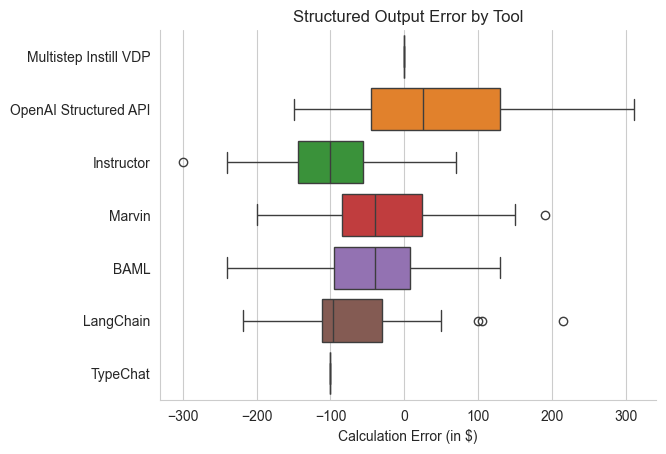

In [45]:
sns.set_style('whitegrid')
sns.boxplot(data=df, orient='y', fill=True)
plt.title('Structured Output Error by Tool')
sns.despine()
plt.xlabel('Calculation Error (in $)')
plt.show()

### Mean Absolute Error

In [36]:
df.abs().mean()

Multistep Instill VDP      0.00
OpenAI Structured API     93.93
Instructor               109.61
Marvin                    71.01
BAML                      72.94
LangChain                 97.23
TypeChat                 100.00
dtype: float64

### Chain-of-Thought Reasoning

In the Structured Outputs in the API [release post](https://openai.com/index/introducing-structured-outputs-in-the-api/), OpenAI suggested that using reasoning chain-of-thought prompting via the data model/schema. In other words, defining a field in the schema called `reasoning_steps`, where the model is requested to share its reasoning, and then take the final calculated answer and place it in the `cost` field. The [`structured-output-reasoning-cot`](https://instill.tech/george_strong/pipelines/structured-output-reasoning-cot/playground) pipeline implements this and is demonstrated in the below cell. As can be observed, its performance still suffers in a similar manner to the standard [`structured-output`](https://instill.tech/george_strong/pipelines/structured-output/playground) pipeline.

Interestingly, in the particular inference example shown below, even though the reasoning was correct, the model was still unable to correctly populate the `cost` field!

In [41]:
openai_structured_reasoning_cot = pipeline.trigger(
    namespace_id="george_strong",
    pipeline_id="structured-output-reasoning-cot",
    data=[{"context": context,
        "question": question}]
)

openai_structured_reasoning_cot_dict = MessageToDict(openai_structured_reasoning_cot)['outputs'][0]['answer']
openai_structured_reasoning_cot_dict

{'name': 'John Doe',
 'reasoning_steps': ['John worked a total of 38 hours this week.',
  'For the first 29 hours, he charges $50 per hour.',
  'So, for 29 hours, the cost is 29 * $50 = $1450.',
  'There are 38 - 29 = 9 additional hours worked.',
  'For these additional hours, he charges 1.7 times his base rate.',
  'His base rate is $50, so 1.7 times the base rate is 1.7 * $50 = $85.',
  'For the 9 additional hours, the cost is 9 * $85 = $765.',
  'Total cost is $1450 (for the first 29 hours) + $765 (for 9 additional hours) = $2215.'],
 'email': 'john.doe@gmail.com',
 'skills': ['Python', 'C++', 'Java'],
 'experience': ['Software Engineer Intern at Google from May 2022 to August 2022',
  'Software Engineer Intern at Facebook from May 2021 to August 2021'],
 'cost': 2378.0}

In [6]:
pipeline.close()